In [1]:
#######################################
### -------- Load libraries ------- ###

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

import tensorflow as tf
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split



In [2]:

#######################################
### --------- Import data --------- ###

# Import data from csv
data = pd.read_csv("amazon/train.csv")
test = pd.read_csv("amazon/test.csv")

data.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [3]:

# Select required columns
data = data[['Text', 'Cat1', 'Cat2', 'Cat3']]
test = test[['Text', 'Cat1', 'Cat2', 'Cat3']]
# Remove a row if any of the three remaining columns are missing
#data = data.dropna()
#test = test.dropna()


In [4]:
# Set your model output as categorical and save in new label col
data['Cat1_label'] = pd.Categorical(data['Cat1'])
data['Cat2_label'] = pd.Categorical(data['Cat2'])
data['Cat3_label'] = pd.Categorical(data['Cat3'])

# Transform your output to numeric
data['Cat1'] = data['Cat1_label'].cat.codes
data['Cat2'] = data['Cat2_label'].cat.codes
data['Cat3'] = data['Cat3_label'].cat.codes

data.head()

,Text,Cat1,Cat2,Cat3,Cat1_label,Cat2_label,Cat3_label
0,The description and photo on this product need...,2,40,242,grocery gourmet food,meat poultry,jerky
1,This was a great book!!!! It is well thought t...,5,27,448,toys games,games,unknown
2,"I am a first year teacher, teaching 5th grade....",5,27,448,toys games,games,unknown
3,I got the book at my bookfair at school lookin...,5,27,448,toys games,games,unknown
4,Hi! I'm Martine Redman and I created this puzz...,5,51,244,toys games,puzzles,jigsaw puzzles


In [5]:

# Split into train and test - stratify over Issue
#data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['Cat1']])



In [6]:
#######################################
### --------- Setup BERT ---------- ###

# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 100

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
#######################################
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') # Ignores padded part of sentences
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
#inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Cat1 = Dense(units=len(data.Cat1_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Cat1')(pooled_output)
Cat2 = Dense(units=len(data.Cat2_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Cat2')(pooled_output)
Cat3 = Dense(units=510, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Cat3')(pooled_output)
outputs = {'Cat1':Cat1,'Cat2':Cat2,'Cat3':Cat3 }
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass_MultiLabel')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass_MultiLabel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          ((None, 100, 768), ( 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][

In [8]:
#######################################
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =  {'Cat1':CategoricalCrossentropy(from_logits = True),'Cat2':CategoricalCrossentropy(from_logits = True),'Cat3':CategoricalCrossentropy(from_logits = True) }
metric = {'Cat1':CategoricalAccuracy('accuracy'),'Cat2':CategoricalAccuracy('accuracy'),'Cat3':CategoricalAccuracy('accuracy') }

#Checkpoints 
filepath = "./chekpoints/Multi_3Cat/chek{epoch:02d}-{Cat1_accuracy:.2f}-{Cat2_accuracy:.2f}-{Cat3_accuracy:.2f}"
checkpoint = ModelCheckpoint(filepath, monitor='Cat1_accuracy', verbose=1, save_best_only=False, mode='max')


# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
y_Cat1 = to_categorical(data['Cat1'])
y_Cat2 = to_categorical(data['Cat2'])
y_Cat3 = to_categorical(data['Cat3'], num_classes=510)

# Tokenize the input (takes some time)
x = tokenizer(
    text=data['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [9]:
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    #x={'input_ids': x['input_ids']},
    y={'Cat1':y_Cat1,'Cat2':y_Cat2,'Cat3':y_Cat3 },
    validation_split=0.2,
    batch_size=26,
    epochs=5,
    callbacks=[checkpoint]) 


Epoch 1/5
1231/1231 [==============================] - ETA: 0s - loss: 7.6437 - Cat1_loss: 0.5674 - Cat2_loss: 2.5595 - Cat3_loss: 4.5167 - Cat1_accuracy: 0.8186 - Cat2_accuracy: 0.3704 - Cat3_accuracy: 0.1725
Epoch 00001: saving model to ./chekpoints/Multi_3Cat/chek01-0.82-0.37-0.17
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./chekpoints/Multi_3Cat/chek01-0.82-0.37-0.17/assets
1231/1231 [==============================] - 1081s 878ms/step - loss: 7.6437 - Cat1_loss: 0.5674 - Cat2_loss: 2.5595 - Cat3_loss: 4.5167 - Cat1_accuracy: 0.8186 - Cat2_accuracy: 0.3704 - Cat3_accuracy: 0.1725 - val_loss: 6.7669 - val_Cat1_loss: 0.5359 - val_Cat2_loss: 2.0950 - val_Cat3_loss: 4.1360 - val_Cat1_accuracy: 0.8295 - val_Cat2_accuracy: 0.4845 - val_Cat3_accuracy: 0.2002
Epoch 2/5

In [10]:
model.save('saved_model/Multi_3Cat')

INFO:tensorflow:Assets written to: saved_model/Multi_3Cat/assets


In [11]:
#model=tf.keras.models.load_model('saved_model/Multi_3Cat')

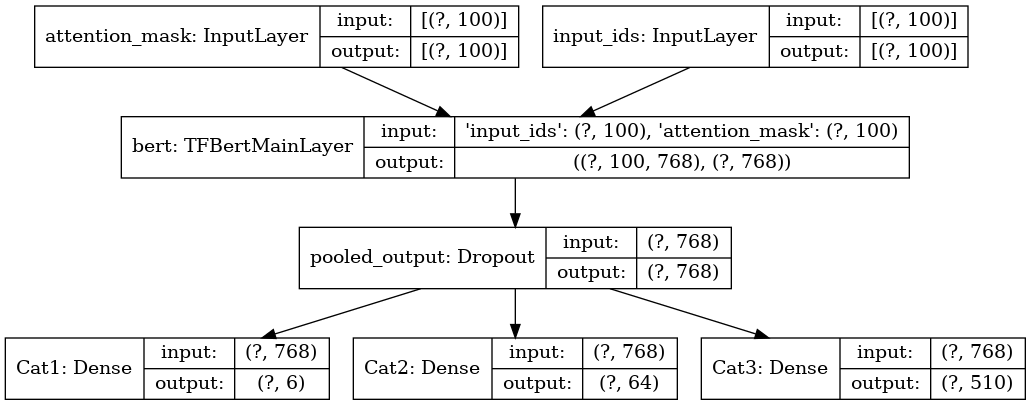

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file="saved_model/Multi_3Cat/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


In [13]:
#######################################
### ----- Evaluate the model ------ ###
# Set your model output as categorical and save in new label col
test['Cat1_label'] = pd.Categorical(test['Cat1'])
test['Cat2_label'] = pd.Categorical(test['Cat2'])
test['Cat3_label'] = pd.Categorical(test['Cat3'])

In [14]:
# Transform your output to numeric
test['Cat1'] = test['Cat1_label'].cat.codes
test['Cat2'] = test['Cat2_label'].cat.codes
test['Cat3'] = test['Cat3_label'].cat.codes

In [15]:
# Ready test data
test_y_cat1 = to_categorical(test['Cat1'])
test_y_cat2 = to_categorical(test['Cat2'])
test_y_cat3 = to_categorical(test['Cat3'], num_classes=510)

In [16]:
test_x = tokenizer(
    text=test['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [17]:
# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},
    y={'Cat1':test_y_cat1,'Cat2':test_y_cat2,'Cat3':test_y_cat3 },
    batch_size=26)

385/385 [==============================] - 103s 268ms/step - loss: 9.5638 - Cat1_loss: 0.5669 - Cat2_loss: 1.8704 - Cat3_loss: 7.1265 - Cat1_accuracy: 0.8203 - Cat2_accuracy: 0.5192 - Cat3_accuracy: 0.0000e+00
